In [17]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, confusion_matrix
import collections
from matplotlib import pyplot as plt
from torchvision import transforms


Separação de dados principais

In [18]:
df = pd.read_csv('classifications.csv')

In [171]:
# Caminho para o diretório desejado
!unzip 'imagens_segmentadas.zip'

'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


In [19]:
caminho_diretorio ='imagem_segmentada/'

#Listar arquivos no diretório
arquivos = os.listdir(caminho_diretorio)

# Exibir os arquivos
print(arquivos)

['10.png', '11.png', '12.png', '13.png', '14.png', '15.png', '16.png', '17.png', '18.png', '19.png', '2.png', '20.png', '21.png', '22.png', '23.png', '24.png', '25.png', '26.png', '27.png', '28.png', '29.png', '3.png', '30.png', '31.png', '32.png', '33.png', '34.png', '35.png', '36.png', '37.png', '38.png', '39.png', '4.png', '40.png', '41.png', '42.png', '43.png', '44.png', '45.png', '46.png', '47.png', '5.png', '6.png', '7.png', '8.png', '9.png']


In [20]:
df['cell_id'] = df['cell_id'].astype(str)

# Mapeando os tipos de células para as imagens
ids_imagens = [os.path.splitext(imagem)[0] for imagem in arquivos]
df_filtrado = df[df['cell_id'].isin(ids_imagens)]

# Caminho completo para o diretório de imagens
caminho_completo = [os.path.join(caminho_diretorio, f"{id}.png") for id in ids_imagens]

# Carregar as imagens
imagens = [Image.open(caminho) for caminho in caminho_completo]

# Exemplo de redimensionamento e normalização
preprocessamento = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imagens_processadas = [preprocessamento(imagem) for imagem in imagens]

# Divisão estratificada entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(
    imagens_processadas, df_filtrado['bethesda_system'],
    test_size=0.2, random_state=42, stratify=df_filtrado['bethesda_system']
)


Quantidade de imagens de treino: 36
Quantidade de imagens de teste: 10


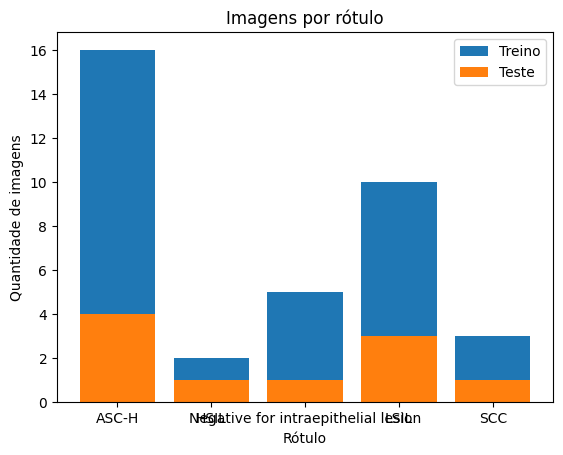

In [21]:
import collections
from matplotlib import pyplot

rotulos = df_filtrado['bethesda_system']

# Checando quantidade de imagens do dataset
print('Quantidade de imagens de treino:', len(x_treino))
print('Quantidade de imagens de teste:', len(x_teste))

# Contando quantidade de imagens por rótulo
counterTreino = collections.Counter(y_treino)
counterTeste = collections.Counter(y_teste)

# Plotando quantidade de imagens de cada rótulo
fig, ax = pyplot.subplots()
rects1 = ax.bar(counterTreino.keys(), counterTreino.values(), label='Treino')
rects2 = ax.bar(counterTeste.keys(), counterTeste.values(), label='Teste')

ax.set_title('Imagens por rótulo')
ax.set_ylabel('Quantidade de imagens')
ax.set_xlabel('Rótulo')
ax.legend()
pyplot.show()

# Classificação de Mahalnobis

Distância de Mahalanobis:  [363.09270687  47.95087199   7.71087389 184.50334742  59.70497553
  62.15281094  26.50480181 108.83440928  42.8987337   31.3900867 ]
Acurácia:  0.1
Matriz de Confusão:
[[1 0]
 [9 0]]


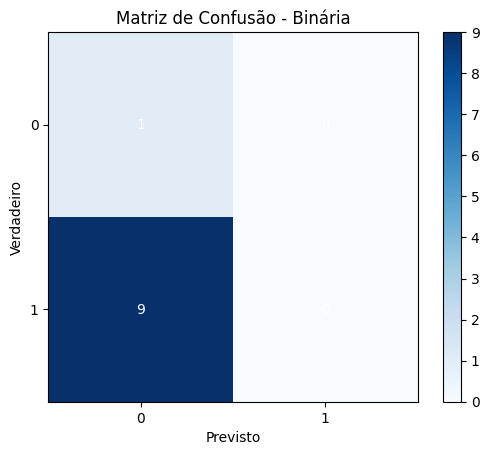

In [22]:
# Converter para numpy arrays
x_treino_np = np.array([img.numpy().flatten() for img in x_treino])
x_teste_np = np.array([img.numpy().flatten() for img in x_teste])

# Mapeamento de classes
class_mapping = {'Negative for intraepithelial lesion': 0}

# Atribuir rótulo 1 para todas as outras classes
for label in df_filtrado['bethesda_system'].unique():
    if label not in class_mapping:
        class_mapping[label] = 1

# Mapeamento dos rótulos verdadeiros
y_true_int = np.array([class_mapping[label] for label in y_teste])

# Aplicar PCA para reduzir a dimensionalidade
n_components = min(x_treino_np.shape[0], x_treino_np.shape[1])
pca = PCA(n_components=n_components)
x_treino_pca = pca.fit_transform(x_treino_np)
x_teste_pca = pca.transform(x_teste_np)

# Calcular a matriz de covariância e seu inverso para o conjunto de treino reduzido
cov_matrix = np.cov(x_treino_pca, rowvar=False)
regularization_term = 1e-5
cov_matrix_regularized = cov_matrix + regularization_term * np.eye(cov_matrix.shape[0])
inv_cov_matrix = np.linalg.inv(cov_matrix_regularized)

# Calcular a distância Mahalanobis
mahalanobis_dist = [distance.mahalanobis(imagem, np.mean(x_treino_pca, axis=0), inv_cov_matrix) for imagem in x_teste_pca]
mahalanobis_dist_array = np.array(mahalanobis_dist)

# Ajustar o limiar conforme necessário
limiar = 5.0

# Criar rótulos previstos com base nas distâncias
y_pred_int = [0 if dist > limiar else 1 for dist in mahalanobis_dist_array]

# Calcular a acurácia usando y_true_int e y_pred_int
acc_binary = accuracy_score(y_true_int, y_pred_int)

# Calcular a matriz de confusão
cm_binary = confusion_matrix(y_true_int, y_pred_int)

# Exibir resultados
print("Distância de Mahalanobis: ", mahalanobis_dist_array)
print("Acurácia: ", acc_binary)
print("Matriz de Confusão:")
print(cm_binary)

# Plotar a matriz de confusão
plt.imshow(cm_binary, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Binária')
plt.colorbar()

# Adicionar anotações
for i in range(cm_binary.shape[0]):
    for j in range(cm_binary.shape[1]):
        plt.text(j, i, str(cm_binary[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(y_true_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

In [32]:
x_treino_np = np.array([img.numpy().flatten() for img in x_treino])
x_teste_np = np.array([img.numpy().flatten() for img in x_teste])

# Mapeamento de classes
class_mapping = {label: i for i, label in enumerate(df_filtrado['bethesda_system'].unique())}

# Mapeamento dos rótulos verdadeiros
y_true_int = np.array([class_mapping[label] for label in y_teste])

# Aplicar PCA para reduzir a dimensionalidade
n_components = min(x_treino_np.shape[0], x_treino_np.shape[1])
pca = PCA(n_components=n_components)
x_treino_pca = pca.fit_transform(x_treino_np)
x_teste_pca = pca.transform(x_teste_np)

# Calcular a matriz de covariância e seu inverso para o conjunto de treino reduzido
cov_matrix = np.cov(x_treino_pca, rowvar=False)
regularization_term = 1e-5
cov_matrix_regularized = cov_matrix + regularization_term * np.eye(cov_matrix.shape[0])
inv_cov_matrix = np.linalg.inv(cov_matrix_regularized)

# Calcular a distância Mahalanobis
mahalanobis_dist = [distance.mahalanobis(imagem, np.mean(x_treino_pca, axis=0), inv_cov_matrix) for imagem in x_teste_pca]
mahalanobis_dist_array = np.array(mahalanobis_dist)

# Ajustar o limiar conforme necessário
limiar = 5.0

# Criar rótulos previstos com base nas distâncias
y_pred_int = np.argmin(mahalanobis_dist_array, axis=0)

# Ajustar a forma de y_true_int
y_true_int = y_true_int.ravel()

# Ajustar a forma de y_pred_int
y_pred_int = y_pred_int.ravel()

# Garantir que y_true_int e y_pred_int tenham o mesmo número de amostras
min_samples = min(len(y_true_int), len(y_pred_int))
y_true_int = y_true_int[:min_samples]
y_pred_int = y_pred_int[:min_samples]

# Calcular a acurácia usando y_true_int e y_pred_int
acc_multiclass = accuracy_score(y_true_int, y_pred_int)

# Calcular a matriz de confusão
cm_multiclass = confusion_matrix(y_true_int, y_pred_int)

# Exibir resultados
print("Distâncias de Mahalanobis: ", mahalanobis_dist_array)
print("Acurácia: ", acc_multiclass)
print("Matriz de Confusão:")
print(cm_multiclass)

# Plotar a matriz de confusão
plt.imshow(cm_multiclass, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão - Multiclasse')
plt.colorbar()

# Adicionar anotações
for i in range(cm_multiclass.shape[0]):
    for j in range(cm_multiclass.shape[1]):
        plt.text(j, i, str(cm_multiclass[i, j]), ha='center', va='center', color='white')

# Adicionar rótulos
classes = np.unique(y_true_int)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [10, 1]

Preparando o dataset para aprendizado de máquina

In [ ]:
# formatar o dataset para funcionar como entrada do keras
x_treino = x_treino.reshape(x_treino.shape[0], 28, 28, 1)
x_teste = x_teste.reshape(x_teste.shape[0], 28, 28, 1)


# # Convertendo as listas de imagens processadas para tensores
# x_treino = torch.stack(x_treino)
# x_teste = torch.stack(x_teste)

# # Adapte o formato para 4 dimensões (batch_size, canais, altura, largura)
# x_treino = x_treino.permute(0, 3, 1, 2)
# x_teste = x_teste.permute(0, 3, 1, 2)

# # Convertendo para float32
# x_treino = x_treino.float()
# x_teste = x_teste.float()

# # Normalizando os valores dos pixels
# x_treino /= 255.0
# x_teste /= 255.0

# # Visualizando as dimensões dos dados
# print("Dimensões dos dados de treino:", x_treino.shape)
# print("Dimensões dos dados de teste:", x_teste.shape)


RuntimeError: ignored

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Definindo a arquitetura da rede neural
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 112 * 112, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Inicializando o modelo
model = CNNModel()

# Imprimindo o resumo do modelo
print(model)

CNNModel(
  (conv1): Conv2d(3, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=351232, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Definindo a arquitetura da rede neural
model = Sequential()
model.add(Conv2D(28, (3, 3), activation='relu', input_shape=(224, 224, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(28, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Inicializando o modelo
adam_optimizer = Adam(lr=0.001)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Visualizando o resumo do modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 28)      784       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 28)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 28)      7084      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 28)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 87808)             0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [ ]:
# Definindo otimizador, função de perda e métrica de eficiência.
from keras.optimizers import Adam
adamOptimizer = Adam(lr=0.001)

model.compile( optimizer=adamOptimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'] )


# Efetuando o treinamento de 10 épocas com o dataset de treino e validando no dataset de validação
history = model.fit( x=x_train, y=y_train, validation_data=(x_val,y_val), epochs=10, batch_size=16, shuffle=False )


# Plotando o histórico de treino

# Histórico de acurácia
pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('Acurácia do modelo no treino e validação')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['Treino', 'Validação'], loc='upper left')
pyplot.show()

# Histórico da função de perda
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Perda do modelo no treino e validação')
pyplot.ylabel('Perda')
pyplot.xlabel('Época')
pyplot.legend(['Treino', 'Validação'], loc='upper left')
pyplot.show()

TypeError: ignored